In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import triton
import triton.language as tl

In [10]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, num_heads, num_kv_heads = None, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads if num_kv_heads is not None else num_heads # Defaults to multi head attention
        self.head_dim = d_model // num_heads

        assert self.num_heads % self.num_kv_heads == 0, "num_heads must be divisible by num_kv_heads"

        self.num_queries_per_kv = self.num_heads // self.num_kv_heads

        # Dimension for each projection
        self.q_proj_dim  = d_model
        self.kv_proj_dim = self.num_kv_heads * self.head_dim

        # Projections
        self.W_q = nn.Linear(self.q_proj_dim, self.q_proj_dim, bias=False)
        self.W_k = nn.Linear(self.q_proj_dim, self.kv_proj_dim, bias=False)
        self.W_v = nn.Linear(self.q_proj_dim, self.kv_proj_dim, bias=False)
        self.W_o = nn.Linear(self.q_proj_dim, self.q_proj_dim, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        batch_size, seq_len, _ = x.shape

        # Applying Linear Projections
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)

        # Repeating k and v for grouped query attention
        # [batch_size, seq_len, num_kv_heads, head_dim] -> [batch_size, seq_len, num_heads,  head_dim]
        # We repeat each key and value head num_queries_per_kv number of times

        if self.num_kv_heads < self.num_heads:
            k = k.repeat_interleave(self.num_queries_per_kv, dim=2)
            v = v.repeat_interleave(self.num_queries_per_kv, dim=2)

        # [batch_size, seq_len, num_heads, head_him] -> [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        #
        context = torch.matmul(attn_weights, v)

        #[batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, num_heads,  head_dim]
        context = context.transpose(1,2)

        context = context.contiguous().view(batch_size, seq_len, self.d_model)

        output = self.W_o(context)

        return output


In [11]:
class MultiQueryAttention(GroupedQueryAttention):
    def __init__(self, d_model, num_heads, dropout = 0.1):
        super().__init__(d_model, num_heads, num_kv_heads=1, dropout=dropout)

    def forward(self,x, mask = None):
        return super().forward(x, mask)

In [12]:
batch_size = 2
seq_len = 10
d_model = 512
num_heads = 8

In [13]:
x = torch.randn(batch_size, seq_len, d_model)

# Standard Multi-Head Attention (MHA)
mha = GroupedQueryAttention(d_model, num_heads, num_kv_heads=num_heads)

# Grouped Query Attention (GQA) with 2 KV heads
gqa = GroupedQueryAttention(d_model, num_heads, num_kv_heads=4)

# Multi-Query Attention (MQA)
mqa = MultiQueryAttention(d_model, num_heads)

# Forward passes
mha_output = mha(x)
gqa_output = gqa(x)
mqa_output = mqa(x)

# Print shapes and parameter counts
mha_params = sum(p.numel() for p in mha.parameters())
gqa_params = sum(p.numel() for p in gqa.parameters())
mqa_params = sum(p.numel() for p in mqa.parameters())

print(f"MHA output shape: {mha_output.shape}")
print(f"GQA output shape: {gqa_output.shape}")
print(f"MQA output shape: {mqa_output.shape}")
print(f"MHA parameter count: {mha_params}")
print(f"GQA parameter count: {gqa_params}")
print(f"MQA parameter count: {mqa_params}")

# Compare parameter savings
print(f"GQA saves {(mha_params - gqa_params) / mha_params * 100:.2f}% parameters compared to MHA")
print(f"MQA saves {(mha_params - mqa_params) / mha_params * 100:.2f}% parameters compared to MHA")

MHA output shape: torch.Size([2, 10, 512])
GQA output shape: torch.Size([2, 10, 512])
MQA output shape: torch.Size([2, 10, 512])
MHA parameter count: 1048576
GQA parameter count: 786432
MQA parameter count: 589824
GQA saves 25.00% parameters compared to MHA
MQA saves 43.75% parameters compared to MHA


In [14]:
@triton.jit
def gqa_forward(
    q_ptr, k_ptr, v_ptr, o_ptr,
    batch_size, seq_len, num_q_heads, num_kv_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    scale,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    num_queries_per_kv: tl.constexpr,
    IS_CAUSAL: tl.constexpr):

    batch_id = tl.program_id(0)
    head_id = tl.program_id(1)
    seq_id = tl.program_id(2)

    start_m = seq_id * BLOCK_SIZE_M

    head_kv_id = head_id // num_queries_per_kv

    q_batch_offset = batch_id * q_batch_stride
    k_batch_offset = batch_id * k_batch_stride
    v_batch_offset = batch_id * v_batch_stride
    o_batch_offset = batch_id * o_batch_stride

    q_head_offset = head_id * q_head_stride
    k_head_offset = head_kv_id * k_head_stride
    v_head_offset = head_kv_id * v_head_stride
    o_head_offset = head_id * o_head_stride

    # Initialise accumulators
    m_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32) - float('inf')
    l_i = tl.zeros([BLOCK_SIZE_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_K], dtype=tl.float32)

    row_indices = start_m + tl.arange(0, BLOCK_SIZE_M)
    row_mask = row_indices < seq_len

    # Loading a query block of size [BLOCK_SIZE_M, BLOCK_SIZE_K]
    q_block = tl.load(
        q_ptr + q_batch_offset + q_head_offset +
        row_indices[:, None] * q_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * q_head_dim_stride,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
        other=0.0
    )

    # Processing blocks of K and V
    for start_n in range(0, seq_len, BLOCK_SIZE_N):
        col_indices = start_n + tl.arange(0, BLOCK_SIZE_N)
        col_mask = col_indices < seq_len

        if IS_CAUSAL:
            causal_mask = row_indices[:, None] >= col_indices[None, :]

        # Loading a key block of size [BLOCK_SIZE_N, BLOCK_SIZE_K]
        k_block = tl.load(
            k_ptr + k_batch_offset + k_head_offset +
            col_indices[:, None] * k_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * k_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        scores = tl.dot(q_block, tl.trans(k_block)) * scale

        if IS_CAUSAL:
            scores = tl.where(causal_mask, scores, float('-inf'))

        # Stable Online Softmax
        m_i_new = tl.maximum(m_i, tl.max(scores, axis=1))

        # Scaling factor
        alpha = tl.exp(m_i - m_i_new)

        # Updating the max value
        m_i = m_i_new

        p = tl.exp(scores - m_i[:, None])

        v_block = tl.load(
            v_ptr + v_batch_offset + v_head_offset +
            col_indices[:, None] * v_seq_stride +
            tl.arange(0, BLOCK_SIZE_K)[None, :] * v_head_dim_stride,
            mask=col_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim),
            other=0.0
        )

        l_i_new = alpha * l_i + tl.sum(p, axis=1)

        acc_new = alpha[:, None] * acc + tl.dot(p, v_block)

        l_i = l_i_new
        acc = acc_new

    # Scaling by normalization factor
    out = acc / l_i[:, None]

    tl.store(
        o_ptr + o_batch_offset + o_head_offset +
        row_indices[:, None] * o_seq_stride +
        tl.arange(0, BLOCK_SIZE_K)[None, :] * o_head_dim_stride,
        out,
        mask=row_mask[:, None] & (tl.arange(0, BLOCK_SIZE_K)[None, :] < head_dim)
    )

In [15]:
class Triton_GQA(nn.Module):
    def __init__(self, d_model, num_heads, num_kv_heads=None, dropout=0.1, causal=False, block_size=64):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads if num_kv_heads is not None else num_heads

        assert num_heads % self.num_kv_heads == 0, "num_heads must be divisible by num_kv_heads"

        self.head_dim = d_model // num_heads
        self.num_queries_per_kv = self.num_heads // self.num_kv_heads

        self.q_proj_dim = d_model
        self.kv_proj_dim = self.num_kv_heads * self.head_dim

        self.causal = causal
        self.block_size = block_size

        self.W_q = nn.Linear(d_model, self.q_proj_dim, bias=False)
        self.W_k = nn.Linear(d_model, self.kv_proj_dim, bias=False)
        self.W_v = nn.Linear(d_model, self.kv_proj_dim, bias=False)
        self.W_o = nn.Linear(self.q_proj_dim, d_model, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_kv_heads, self.head_dim)

        # [batch_size, seq_len, num_heads, head_dim] -> [batch_size, num_heads, seq_len, head_dim]
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        output = torch.empty_like(q)

        scale = 1.0 / math.sqrt(self.head_dim)

        grid = (
            batch_size,
            self.num_heads,
            triton.cdiv(seq_len, self.block_size)
        )

        # Ensure block_k is a power of 2
        block_k = 1
        while block_k < self.head_dim:
            block_k *= 2

        # Launch kernel
        gqa_forward[grid](
            q, k, v, output,
            batch_size, seq_len, self.num_heads, self.num_kv_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            output.stride(0), output.stride(1), output.stride(2), output.stride(3),
            scale,
            BLOCK_SIZE_M=self.block_size,
            BLOCK_SIZE_N=self.block_size,
            BLOCK_SIZE_K=block_k,
            num_queries_per_kv=self.num_queries_per_kv,
            IS_CAUSAL=self.causal,
        )

        output = output.permute(0, 2, 1, 3)
        output = output.contiguous().view(batch_size, seq_len, self.d_model)

        if self.dropout.p > 0.0 and self.training:
            output = self.dropout(output)

        output = self.W_o(output)

        return output

In [16]:
# Define constants
DEVICE = torch.device('cuda')
D_MODEL = 768
NUM_HEADS = 12
BATCH_SIZE = 1

# flash-attn library typically uses these block sizes
FLASH_BLOCK_SIZE = 64
FLASH_SUB_BLOCK_SIZE = 16

In [24]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=[2**i for i in range(8, 14)],  # 256 to 4096
        x_log=True,
        line_arg='provider',
        line_vals=['torch', 'Triton_GQA'],
        line_names=['PyTorch', 'Triton_GQA'],
        styles=[('blue', '-'), ('red', '-')],
        plot_name='attention-performance',
        args={'d_model': D_MODEL, 'num_heads': NUM_HEADS, 'batch_size': BATCH_SIZE},
    )
)
def benchmark_attention(seq_len, provider, d_model, num_heads, batch_size):
    """Benchmark different attention implementations."""
    x = torch.randn((batch_size, seq_len, d_model), device=DEVICE)

    # Create the appropriate model based on provider
    if provider == 'torch':
        model = GroupedQueryAttention(d_model, num_heads).to(DEVICE)
        run_func = lambda: model(x)

    elif provider == 'Triton_GQA':
        model = Triton_GQA(d_model, num_heads, causal=False).to(DEVICE)
        run_func = lambda: model(x)

    else:
        raise ValueError(f"Unknown provider: {provider}")

    # Warmup
    for _ in range(3):
        _ = run_func()
    torch.cuda.synchronize()

    # Benchmark
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(run_func, quantiles=quantiles)

    return ms, max_ms, min_ms

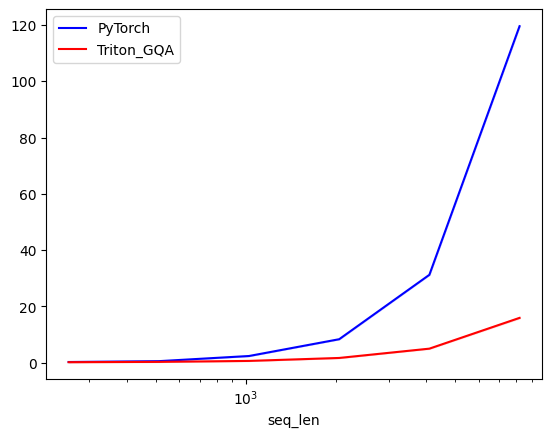

attention-performance:
   seq_len     PyTorch  Triton_GQA
0    256.0    0.264192    0.200704
1    512.0    0.564224    0.306176
2   1024.0    2.394112    0.651264
3   2048.0    8.360449    1.701888
4   4096.0   31.242241    5.008896
5   8192.0  119.593987   15.944704


In [25]:
benchmark_attention.run(show_plots=True, print_data=True)